In [1]:
from IPython.display import display, HTML, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
def gen_df(json_file):
    FILE_PATH = '../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]

            client_bitrates = nservs_df['bitrate']['client']
            nservs_df['bitrate']['client'] = \
                {'avg': np.mean(client_bitrates), 'std': np.std(client_bitrates, ddof=1)}

            client_cycles = nservs_df['cycles']['client']
            nservs_df['cycles']['client'] = \
                {'avg': np.mean(client_cycles), 'std': np.std(client_cycles, ddof=1)}

            servers_bitrates = []
            servers_cycles = []
            for serv_idx in range(nservs):
                bitrates = [arr[serv_idx] for arr in nservs_df['bitrate']['servers']]
                servers_bitrates.append(
                    {'avg': np.mean(bitrates), 'std': np.std(bitrates, ddof=1)})

                cycles = [arr[serv_idx] for arr in nservs_df['cycles']['servers']]
                servers_cycles.append(
                    {'avg': np.mean(cycles), 'std': np.std(cycles, ddof=1)})

            nservs_df['bitrate']['servers'] = servers_bitrates
            nservs_df['cycles']['servers'] = servers_cycles
            
    return df

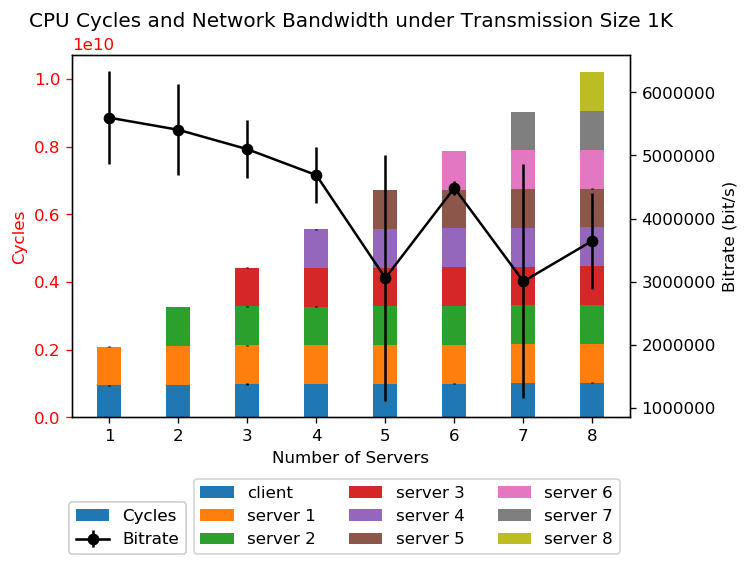

---

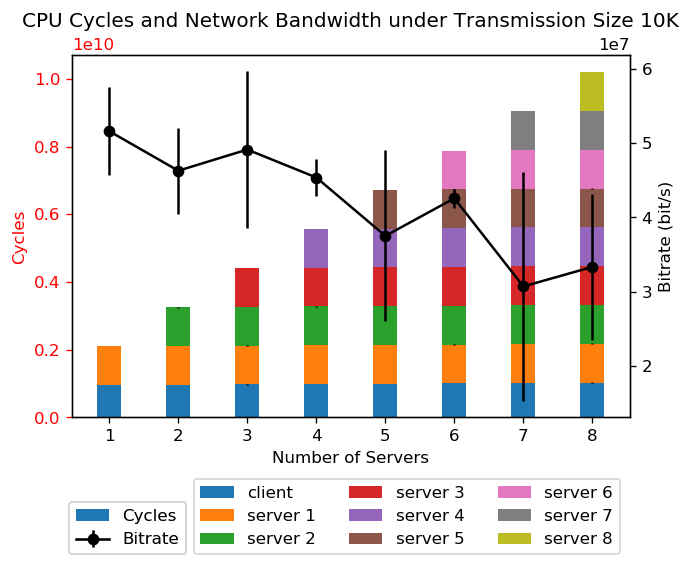

---

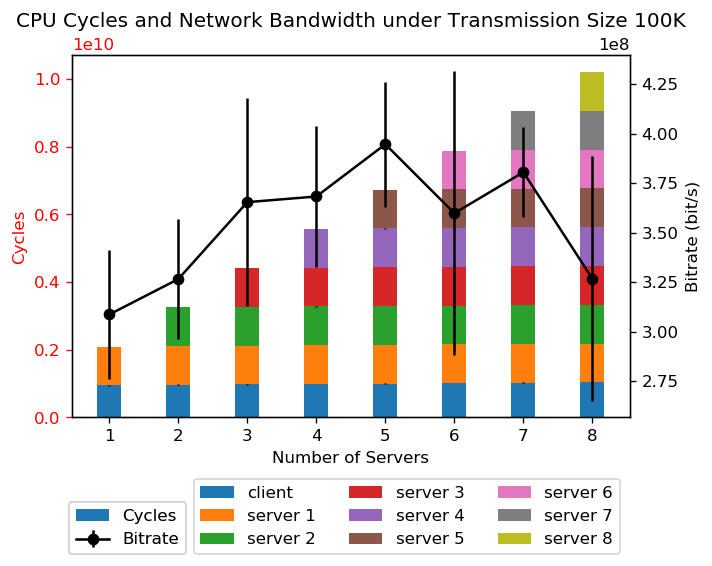

---

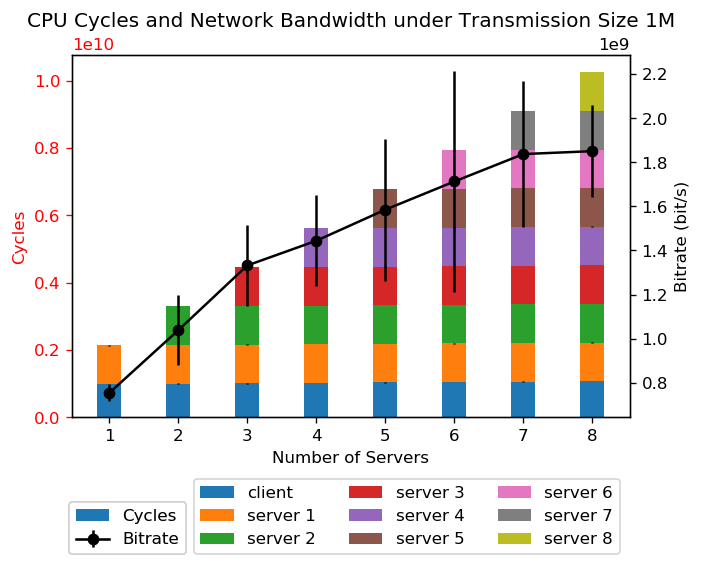

---

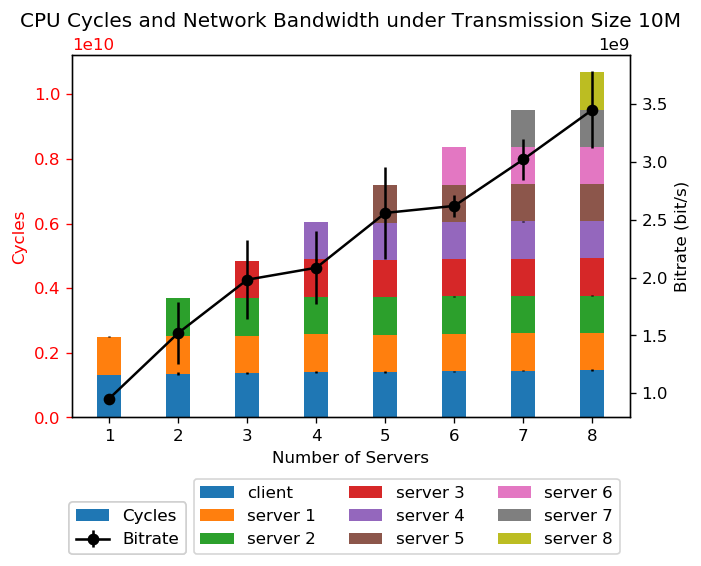

---

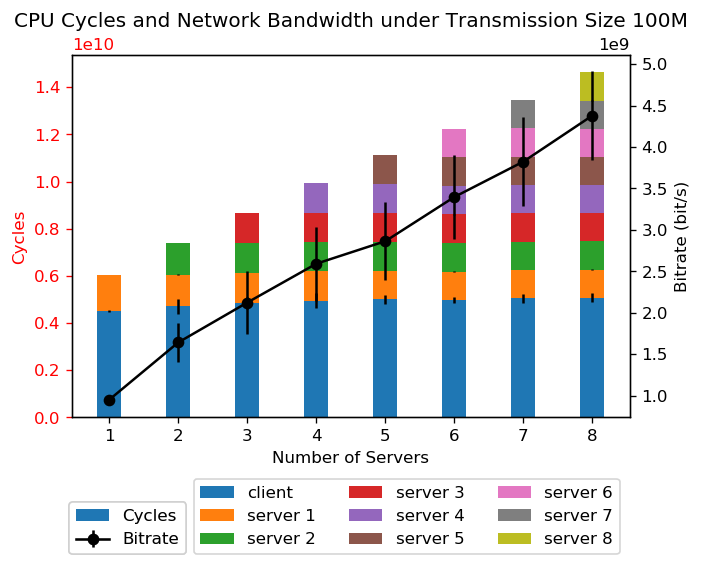

---

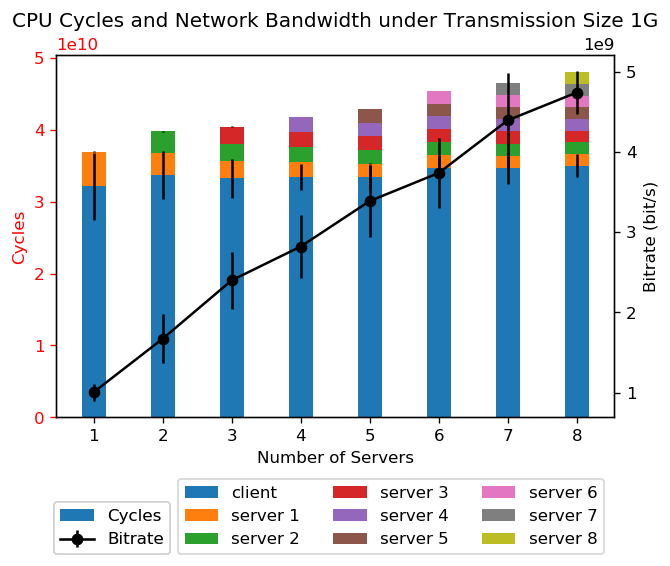

---

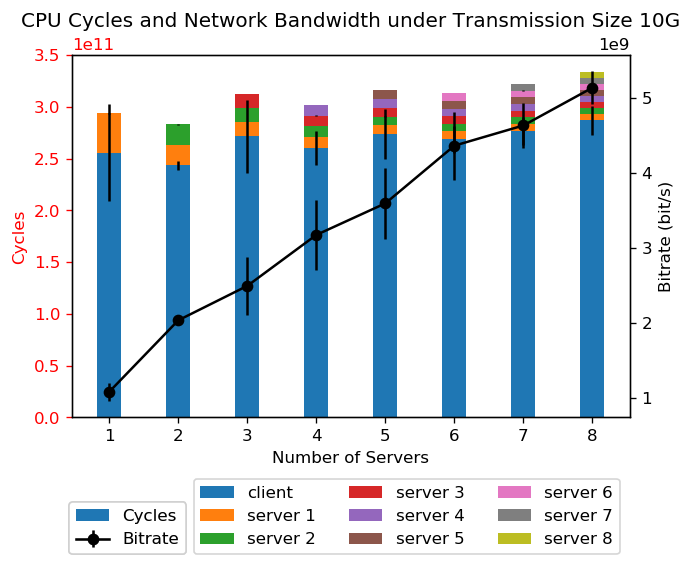

---

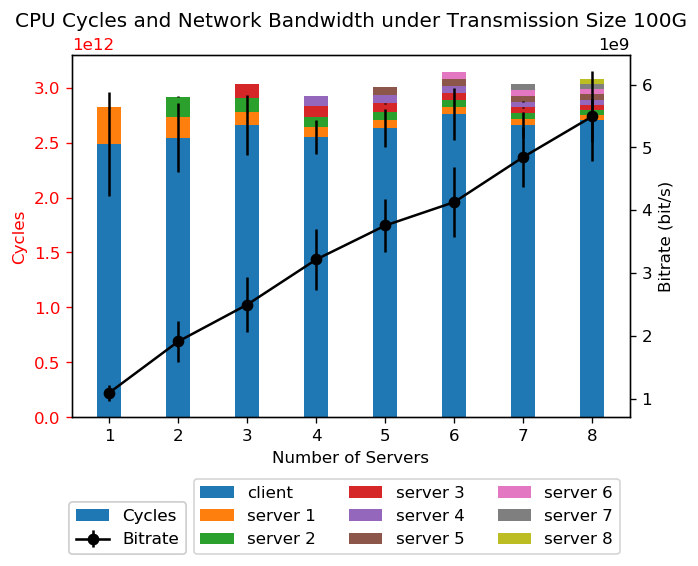

---

In [3]:
FILE_PATH_SERVER_FILTERING = 'output_raw_8servs_arm/result.json'
FILE_PATH_CLIENT_FILTERING = 'output_raw_8servs_arm/result.json'

df_server_filtering = gen_df(FILE_PATH_SERVER_FILTERING)
df_client_filtering = gen_df(FILE_PATH_CLIENT_FILTERING)

N = len(df_server_filtering.index)
ind = np.arange(N)  # the x locations for the groups
width = 0.35        # the width of the bars


def human2kbytes(string):
    num = int(''.join(filter(str.isdigit, string)))
    if string.endswith('K'):
        return num
    elif string.endswith('M'):
        return num << 10
    else:
        return num << 20

for size in sorted(df_server_filtering.columns, key=human2kbytes):
    fig, ax1 = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)
    
    # Draw bins for Cycles
    cycle_bars = []
    
    size_df = df_server_filtering[size]

    client_cycle_avgs = [size_df[nservs]['cycles']['client']['avg'] for nservs in size_df.index]
    client_cycle_stds = [size_df[nservs]['cycles']['client']['std'] for nservs in size_df.index]
    
    bar = ax1.bar(ind,
                  client_cycle_avgs,
                  width,
                  yerr=client_cycle_stds)
    cycle_bars.append(bar)

    last_bottom = client_cycle_avgs
    for serv_idx in range(N):
        server_cycle_avgs = []
        server_cycle_stds = []

        for nservs in size_df.index:
            server_cycle_arr = size_df[nservs]['cycles']['servers']
            cycle_avg = 0
            cycle_std = 0
            
            if len(server_cycle_arr) - 1 >= serv_idx:
                cycle_avg = server_cycle_arr[serv_idx]['avg']
                cycle_std = server_cycle_arr[serv_idx]['std']
                
            server_cycle_avgs.append(cycle_avg)
            server_cycle_stds.append(cycle_std)
            
        
                
        bar = ax1.bar(ind, server_cycle_avgs, width,
                 bottom=last_bottom, yerr=server_cycle_stds)
        cycle_bars.append(bar)
        
        last_bottom = np.sum([last_bottom, server_cycle_avgs], axis=0)
    
    ax1_clr = 'r'
    ax1.set_ylabel('Cycles', color=ax1_clr)
    ax1.tick_params('y', colors=ax1_clr)
    
    ax1.set_xlabel('Number of Servers')
    
    ax1.legend(
        cycle_bars,
        ['client'] + ['server ' + str(idx) for idx in size_df.index],
        ncol=3,
        loc=8,
        bbox_to_anchor=(0.6, -0.4))
    
    
    # Draw lines for Bitrate
    ax2 = ax1.twinx()
    
    bitrate_color = 'black'
    bitrate_bar = ax2.errorbar(
        ind,
        [size_df[nservs]['bitrate']['client']['avg'] for nservs in size_df.index],
        yerr=[size_df[nservs]['bitrate']['client']['std'] for nservs in size_df.index],
        fmt='-o',
        color=bitrate_color)
    
    ax2.set_ylabel('Bitrate (bit/s)', color=bitrate_color)
    ax2.tick_params('y', colors=bitrate_color)
    type_legend = ax2.legend(
        [cycle_bars[0], bitrate_bar],
        ['Cycles', 'Bitrate'],
        loc=8,
        bbox_to_anchor=(0.1, -0.4))
    
    plt.gca().add_artist(type_legend)
    plt.xticks(ind, size_df.index)
    plt.title('CPU Cycles and Network Bandwidth under Transmission Size ' + size, y=1.05)

    plt.show()
    display(Markdown('---'))